In [29]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec  
import os

import cv2
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F

from sklearn.kernel_approximation import RBFSampler
from sklearn import preprocessing
from einops import rearrange

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Set device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


torch.Size([3, 1365, 2048])


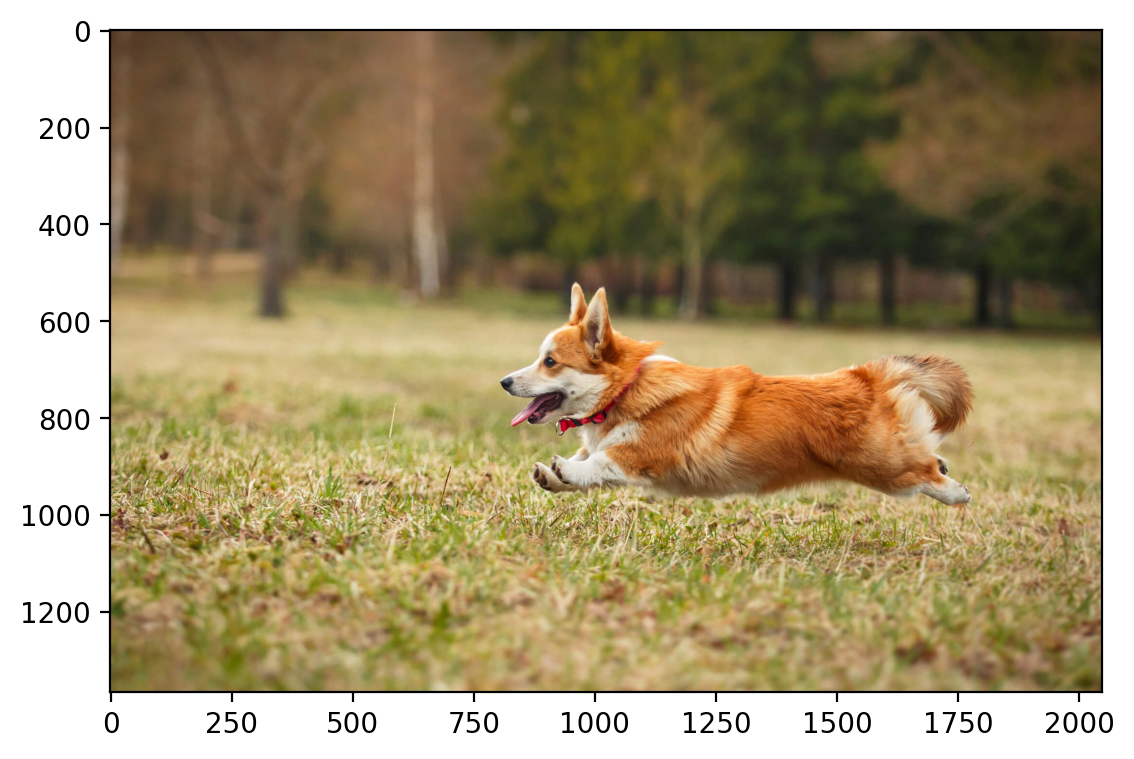

In [8]:
original_image = torchvision.io.read_image("dog.jpg")
print(original_image.shape)
plt.imshow(original_image.permute(1, 2, 0))

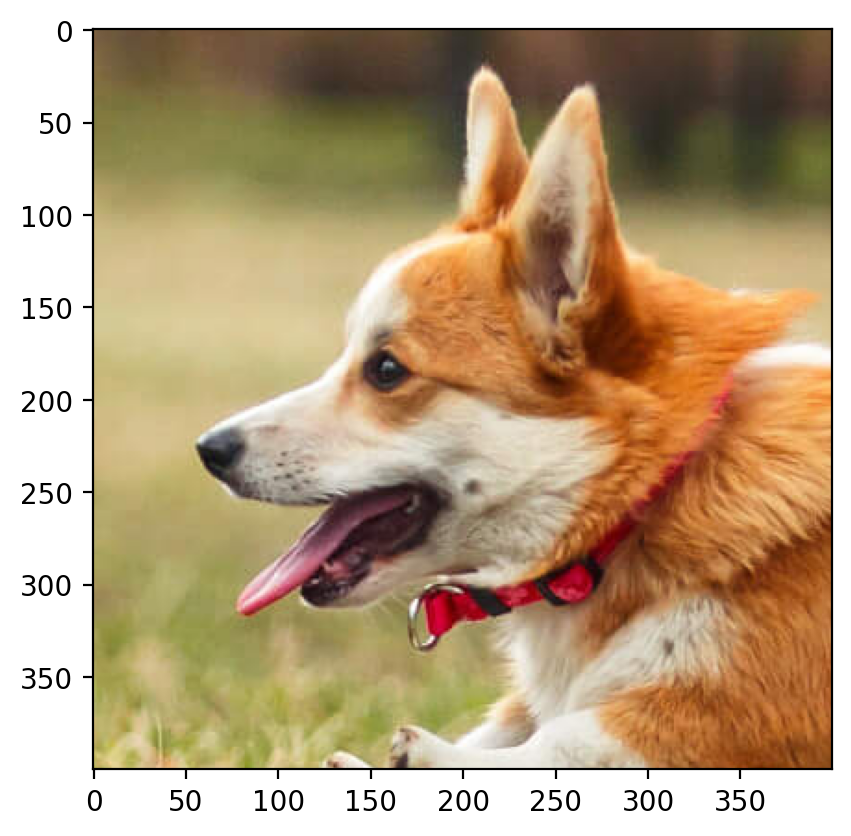

In [9]:
cropped_image = torchvision.transforms.functional.crop(original_image.cpu(), 500, 750, 400, 400)
cropped_image.shape
plt.imshow(cropped_image.permute(1, 2, 0))

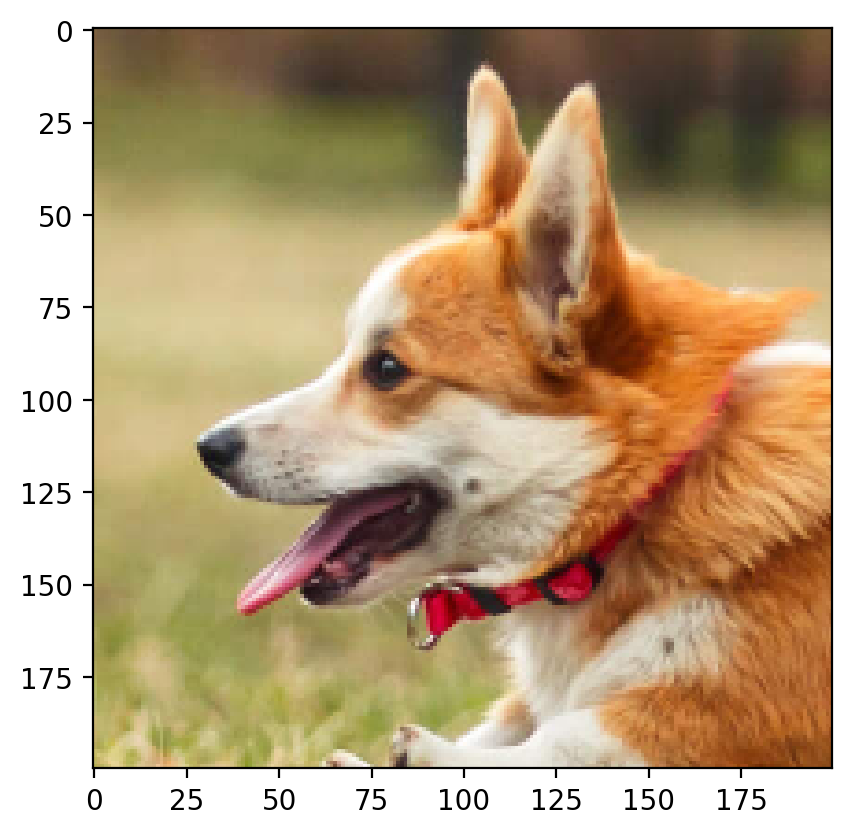

In [10]:
scaled_image = cv2.resize(cropped_image.permute(1,2,0).numpy(), (200, 200))
scaled_image = torch.tensor(scaled_image)
plt.imshow(scaled_image)

In [11]:
scaler_img = preprocessing.MinMaxScaler().fit(scaled_image.reshape(-1, 1)) # Reshape the image to 2D array
img_scaled = scaler_img.transform(scaled_image.reshape(-1, 1)).reshape(scaled_image.shape) # Scaling and reshaping back to the original image shape
img_scaled = torch.tensor(img_scaled) # Converting image to a PyTorch tensor
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.4824, 0.3843, 0.2510],
         [0.4549, 0.3608, 0.2510],
         [0.4510, 0.3569, 0.2471],
         ...,
         [0.4549, 0.3412, 0.2157],
         [0.4549, 0.3412, 0.2157],
         [0.4510, 0.3373, 0.2118]],

        [[0.4902, 0.3765, 0.2510],
         [0.4627, 0.3686, 0.2588],
         [0.4549, 0.3608, 0.2510],
         ...,
         [0.4549, 0.3412, 0.2157],
         [0.4549, 0.3412, 0.2157],
         [0.4510, 0.3373, 0.2118]],

        [[0.4824, 0.3686, 0.2471],
         [0.4588, 0.3647, 0.2588],
         [0.4549, 0.3608, 0.2549],
         ...,
         [0.4471, 0.3255, 0.2039],
         [0.4471, 0.3255, 0.2039],
         [0.4510, 0.3294, 0.2078]],

        ...,

        [[0.7529, 0.7098, 0.3608],
         [0.7765, 0.7137, 0.4118],
         [0.8118, 0.7451, 0.4588],
         ...,
         [0.5686, 0.3255, 0.1294],
         [0.5333, 0.2902, 0.0941],
         [0.5216, 0.2745, 0.0784]],

        [[0.7412, 0.7137, 0.3922],
         [0.7961, 0.6941, 0.4000],
         [0.

In [12]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    
    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    
    num_channels, height, width = img.shape
    
    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [13]:
img_x, img_y = create_coordinate_map(img_scaled.permute(2,0,1))

img_x.shape, img_y.shape

(torch.Size([40000, 2]), torch.Size([40000, 3]))

In [14]:
# Initialize the MinMaxScaler to scale between -1 and 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(img_x.cpu())

# Scaling the X data (scaling is done on CPU)
img_X_scaled = scaler_X.transform(img_x.cpu())

# Converting the scaled data to a PyTorch tensor
img_X_scaled = torch.tensor(img_X_scaled)

# Moving the tensor to the specified device
img_X_scaled = img_X_scaled.to(device)

# Ensuring the data type is float
img_X_scaled = img_X_scaled.float()

In [15]:
from sklearn.kernel_approximation import RBFSampler
rff = RBFSampler(n_components=15000, gamma=1/(2 * 0.008**2), random_state=42) #Creating random fourier features

In [16]:
def create_rff_features(X):
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)  
    

In [17]:
X_rff = create_rff_features(img_X_scaled) #Creating random fourier features with 15000 features and sigma=0.008
X_rff.shape

torch.Size([40000, 15000])

In [18]:
class Model(nn.Module):
    def __init__(self,input_dim, output_dim):
        super(Model,self).__init__()
        self.linear1 = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        x = self.linear1(x)
        return x
    
model = Model(15000, 3).to(device)

In [19]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float (learning rate)
    X: torch.Tensor of shape (num_samples, 2 (X,Y))
    Y: torch.Tensor of shape (num_samples, 3 (R,G,B))
    """

    loss_hist = []
    criterion = nn.MSELoss() #Mean squared error loss function
    optimizer = torch.optim.Adam(net.parameters(), lr=lr) 
    for epoch in range(epochs):
        optimizer.zero_grad() #Initialize to zero

        # Computing the loss
        outputs = net(X)
        loss = criterion(outputs, Y)
        loss.backward()
        loss_hist.append(loss.item())
        # Updating the parameters
        optimizer.step()

        # Printing the loss for each epoch (for testing)
        if verbose and epoch % 10 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")

    return loss_hist

In [28]:
loss = train(model, 0.01, X_rff, img_y, 1000)

Epoch 0 loss: 0.005431
Epoch 10 loss: 0.004907
Epoch 20 loss: 0.004423
Epoch 30 loss: 0.004007
Epoch 40 loss: 0.003645
Epoch 50 loss: 0.003326
Epoch 60 loss: 0.003043
Epoch 70 loss: 0.002791
Epoch 80 loss: 0.002565
Epoch 90 loss: 0.002362
Epoch 100 loss: 0.002179
Epoch 110 loss: 0.002014
Epoch 120 loss: 0.001865
Epoch 130 loss: 0.001729
Epoch 140 loss: 0.001607
Epoch 150 loss: 0.001495
Epoch 160 loss: 0.001393
Epoch 170 loss: 0.001301
Epoch 180 loss: 0.001217
Epoch 190 loss: 0.001141
Epoch 200 loss: 0.001071
Epoch 210 loss: 0.001008
Epoch 220 loss: 0.000950
Epoch 230 loss: 0.000898
Epoch 240 loss: 0.000850
Epoch 250 loss: 0.000807
Epoch 260 loss: 0.000768
Epoch 270 loss: 0.000732
Epoch 280 loss: 0.000700
Epoch 290 loss: 0.000670
Epoch 300 loss: 0.000644
Epoch 310 loss: 0.000620
Epoch 320 loss: 0.000598
Epoch 330 loss: 0.000578
Epoch 340 loss: 0.000560
Epoch 350 loss: 0.000544
Epoch 360 loss: 0.000530
Epoch 370 loss: 0.000517
Epoch 380 loss: 0.000505
Epoch 390 loss: 0.000494
Epoch 400 l

In [17]:
test_width = 400
test_height = 400
w_coords = torch.arange(test_width).repeat(test_height, 1)
h_coords = torch.arange(test_height).repeat(test_width, 1).t()
w_coords = w_coords.reshape(-1)/2
h_coords = h_coords.reshape(-1)/2
X = torch.stack([h_coords, w_coords], dim=1).float()

scaler_X_test = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(img_x.cpu())

test_image = scaler_X_test.transform(X.cpu())

# Converting the scaled data to a PyTorch tensor
test_image = torch.tensor(test_image)

# Moving the tensor to the specified device
test_image = test_image.to(device)

# Ensuring the data type is float
test_image = test_image.float()

X_rff_test = rff.transform(test_image.cpu())

In [18]:
print(X_rff[:1])
print(X_rff_test[:1])

tensor([[ 0.0038, -0.0023, -0.0014,  ..., -0.0115, -0.0063, -0.0080]])
[[ 0.00379986 -0.00230556 -0.00136012 ... -0.01153356 -0.00630409
  -0.00798253]]


In [19]:
def super_resolution(model, X):
    """
    model: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2 (X,Y))
    """
    with torch.no_grad():
        model.eval()
        Y = model(X)
    return Y

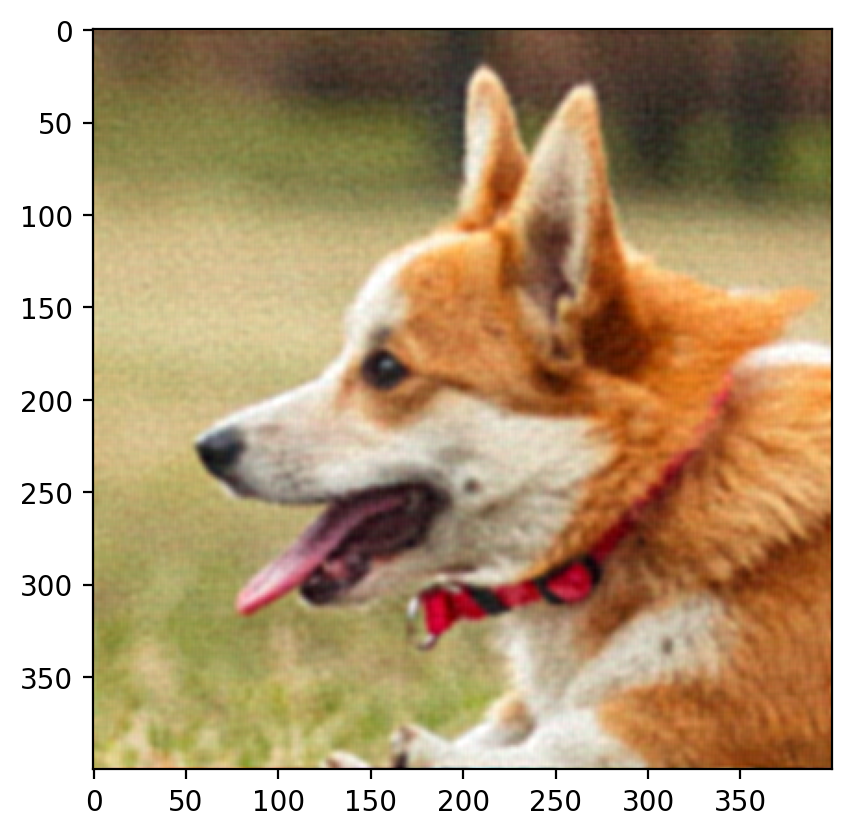

In [21]:
super_resolution_img = super_resolution(model, torch.tensor(X_rff_test))
super_resolution_img = super_resolution_img.cpu().numpy()
super_resolution_img = super_resolution_img.reshape(400, 400, 3)
super_resolution_img = np.clip(super_resolution_img, 0, 1)
plt.imshow(super_resolution_img)

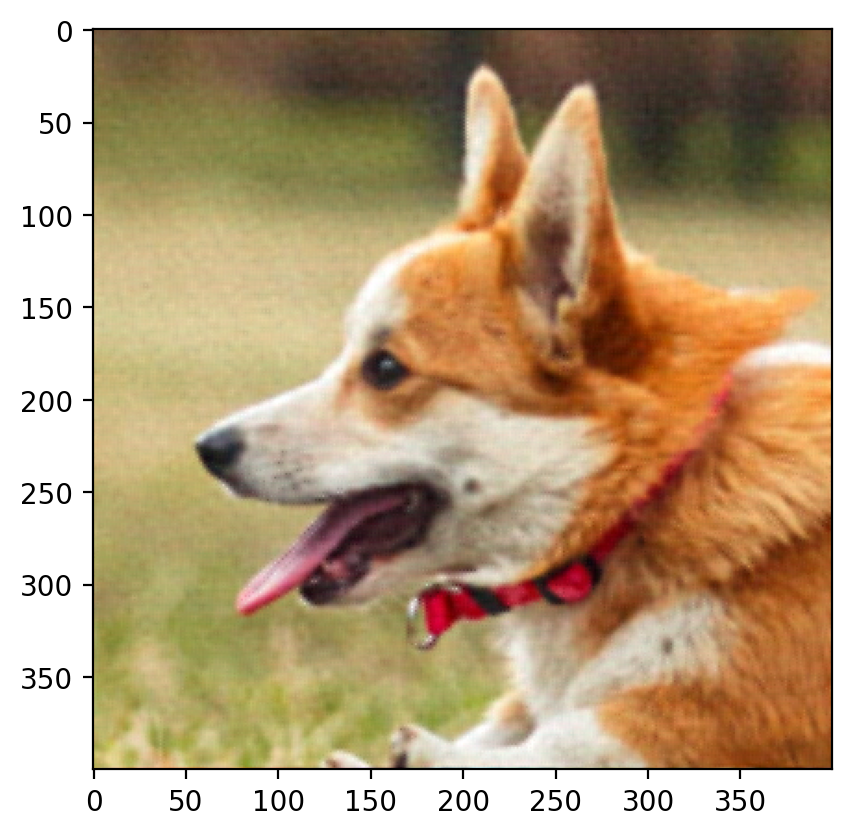

In [27]:
for i in range(0,len(super_resolution_img),2):
    for j in range(0,len(super_resolution_img[0]),2):
        super_resolution_img[i][j] = img_scaled[i//2][j//2]
plt.imshow(super_resolution_img)

In [21]:
# calculate the rmse
def calculate_rmse(original_values, predicted_values):
    return np.sqrt(((original_values - predicted_values) ** 2).mean())

In [22]:
#calculate the psnr
def calculate_psnr(maximum, rmse):
    return 10 * np.log10(maximum**2 / rmse)

In [23]:
RMSE = calculate_rmse(cropped_image,super_resolution_img)
PSNR = calculate_psnr(cropped_image.max(), RMSE)

NameError: name 'super_resolution_img' is not defined

In [27]:
print("RMSE: ", RMSE)
print("PSNR: ", PSNR)

NameError: name 'RMSE' is not defined